# **0.0. Imports**

In [12]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import datetime
import matplotlib.gridspec as gridspec
from tabulate import tabulate
from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
import xgboost as xgb
import random
import pickle
from IPython.core.display import display, HTML
import warnings
warnings.filterwarnings( 'ignore' )
from flask import Flask, request, Response

## **0.1. Helper Functions**

In [13]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

def cramer_v(x, y):
  cm = pd.crosstab(x, y).to_numpy()
  n = cm.sum()
  r, k = cm.shape

  chi2 = stats.chi2_contingency(cm)[0]
  chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

  kcorr = k - (k-1)**2/(n-1)
  rcorr = r - (r-1)**2/(n-1)

  return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

def mean_percentage_error(y, yhat):
  return np.mean((y-yhat)/y)

def mean_absolute_percentage_error(y, yhat):
  return np.mean(np.abs((y-yhat)/y))

def ml_error(model_name, y, yhat):
  mae = mean_absolute_error(y, yhat)
  mape = mean_absolute_percentage_error(y, yhat)
  rmse = np.sqrt(mean_squared_error(y, yhat))

  return pd.DataFrame({'Model Name' : model_name,
                       'MAE' : mae,
                       'MAPE' : mape,
                       'RMSE' : rmse},index=[0])
  
def cross_validation(x_training ,kfold, model_name, model,verbose = False):
  mae_list = []
  mape_list = []
  rmse_list = []
  for k in reversed(range(1, kfold+1)):
    if verbose:
      print('\nKFold Number: {}'. format(k))
    #start and end date validation
    validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
    validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

    #Filter dataset
    training = x_training[x_training['date'] < validation_start_date]
    validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

    #training and validation dataset
    #training
    xtraining = training.drop(['date', 'sales'], axis=1)
    ytraining = training['sales']

    #validation
    xvalidation = validation.drop(['date', 'sales'], axis=1)
    yvalidation = validation['sales']

    #Model
    m = model.fit(xtraining, ytraining)

    #Prediction
    yhat = m.predict(xvalidation)

    #Performace
    m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

    #store performace of each kfold interation
    mae_list.append(m_result['MAE'])
    mape_list.append(m_result['MAPE'])
    rmse_list.append(m_result['RMSE'])

  return pd.DataFrame({'Model Name': model_name,
    'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
    'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
    'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)}, index=[0])

In [14]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## **0.2. Loading Data**

In [15]:
df_sales_raw = pd.read_csv('data/train.csv',
                   low_memory=False)
df_store_raw = pd.read_csv('data/store.csv',
                   low_memory=False)


df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# **1.0. Passo 01 - Descrição dos Dados**

## **1.1. Rename Columns**

In [5]:
df1 = df_raw.copy()

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## **1.2. Data Dimensions**

In [8]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## **1.3. Data Types**

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## **1.4. Check NA**

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## **1.5. Fillout NA**

In [11]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## **1.6. Change Types**

In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)


## **1.7. Descriptive Statiscal**

In [13]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### **1.7.1 Numerical Attributes**


In [14]:
#Central Tendency - mean e median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispercion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#Concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### **1.7.2 Categorical Attributes**

In [15]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

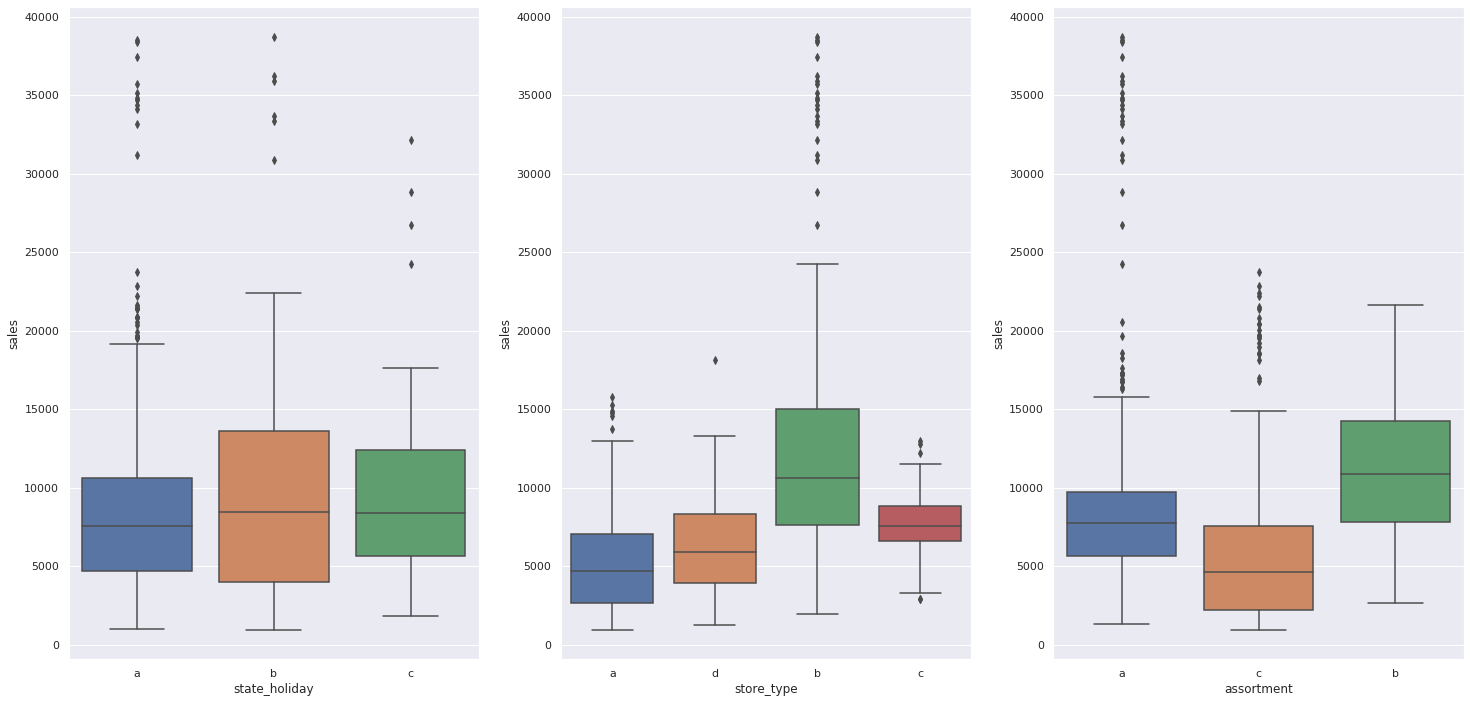

In [16]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1)

# **2.0. Passo 02 - Feature Engineering**

## **2.1 Mapa Mental de Hipoteses**

In [17]:
df2 = df1.copy()

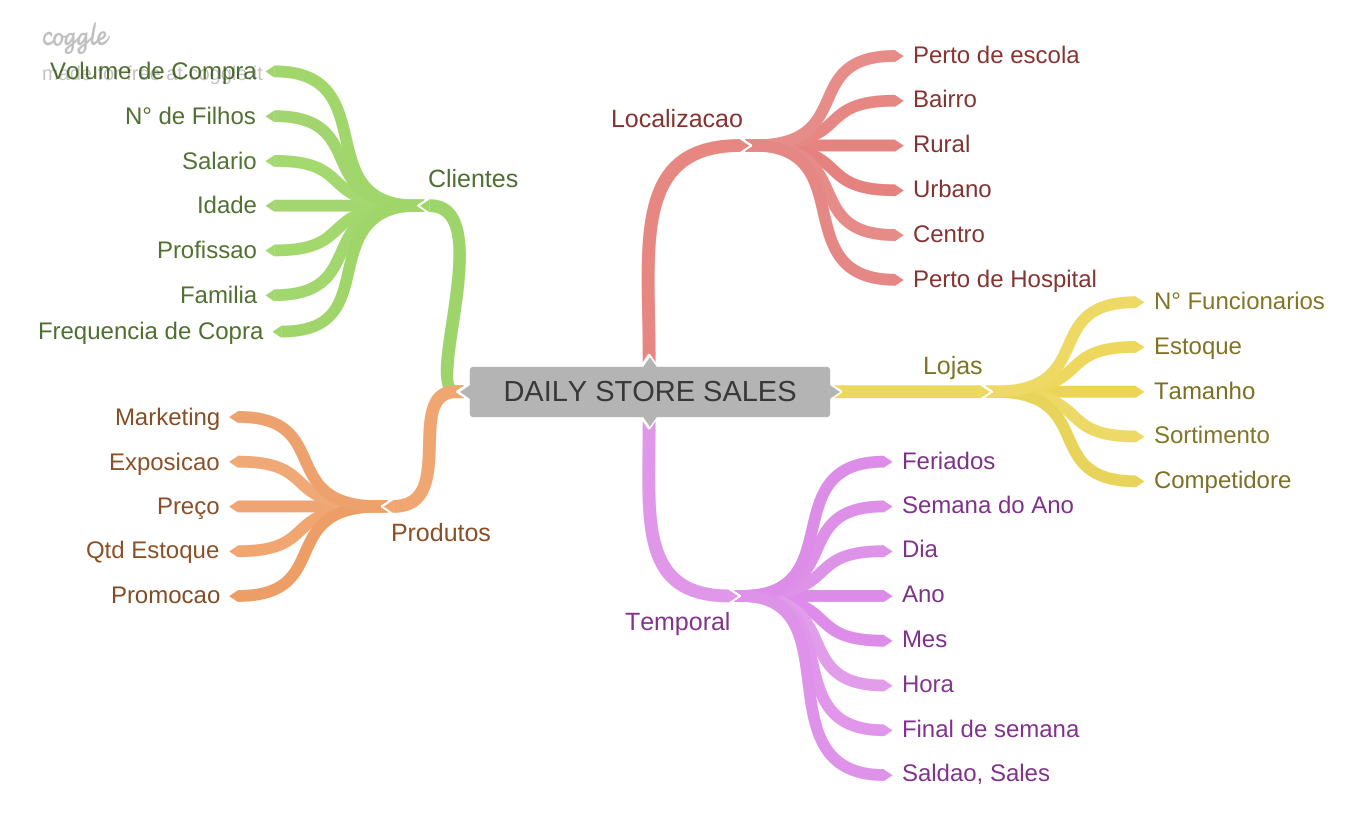

In [18]:
Image('img/MindMapHypothesis.png')

## **2.1 Criação das Hipoteses**

### **2.1.1 Hipoteses Loja**

**1.** Loja com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com mais competidores proximos deveriam vender menos.

**6.** Lojas com competidore a mais tempo deveriam vender mais.

### **2.1.2 Hipoteses Produto**

**1.** Lojas quem investem mais em marketing deveriam vender mais.

**2.** Lojas que expoem mais os produtos deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas com promoçoes mais agressivas deveriam vender mais.

**5.** Loja com promoçoes ativas a mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoçoes deveriam vender mais.

**7.** Loja com mais promoçoes consecutivas deveriam vender mais.

### **2.1.3 Hipoteses Tempo**

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**5.** Lojas deveriam vender menos nos finais de semana.

**6.** Lojas deveriam vender menos durante  os feriados escolares.

## **2.2. Lista final de Hipoteses**


**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com mais competidores proximos deveriam vender menos.

**3.** Lojas com competidore a mais tempo deveriam vender mais.



---



**4.** Loja com promoçoes ativas a mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoçoes deveriam vender mais.

**6.** Loja com mais promoçoes consecutivas deveriam vender mais.



---



**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**11.** Lojas deveriam vender menos nos finais de semana.

**12.** Lojas deveriam vender menos durante  os feriados escolares.

## **2.3. Feature Engineering**

In [19]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )



In [20]:
df2.head(6).T

,0,1,2,3,4,5
store,1,2,3,4,5,6
day_of_week,5,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822,5651
customers,555,625,821,1498,559,589
open,1,1,1,1,1,1
promo,1,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1,1
store_type,c,a,a,c,a,a


# **3.0. Passo 03 - Filtragem de variaveis**

In [21]:
df3 =df2.copy()
df3.head(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## **3.1. Filtragem das linhas**

In [22]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## **3.2. Selecao das Colunas**

In [23]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [24]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# **4.0. Passo 04 - Analise Exploratoria dos Dados**

In [25]:
df4 = df3.copy()

## **4.1. Analise Univariada**

### **4.1.1 Response Variable**

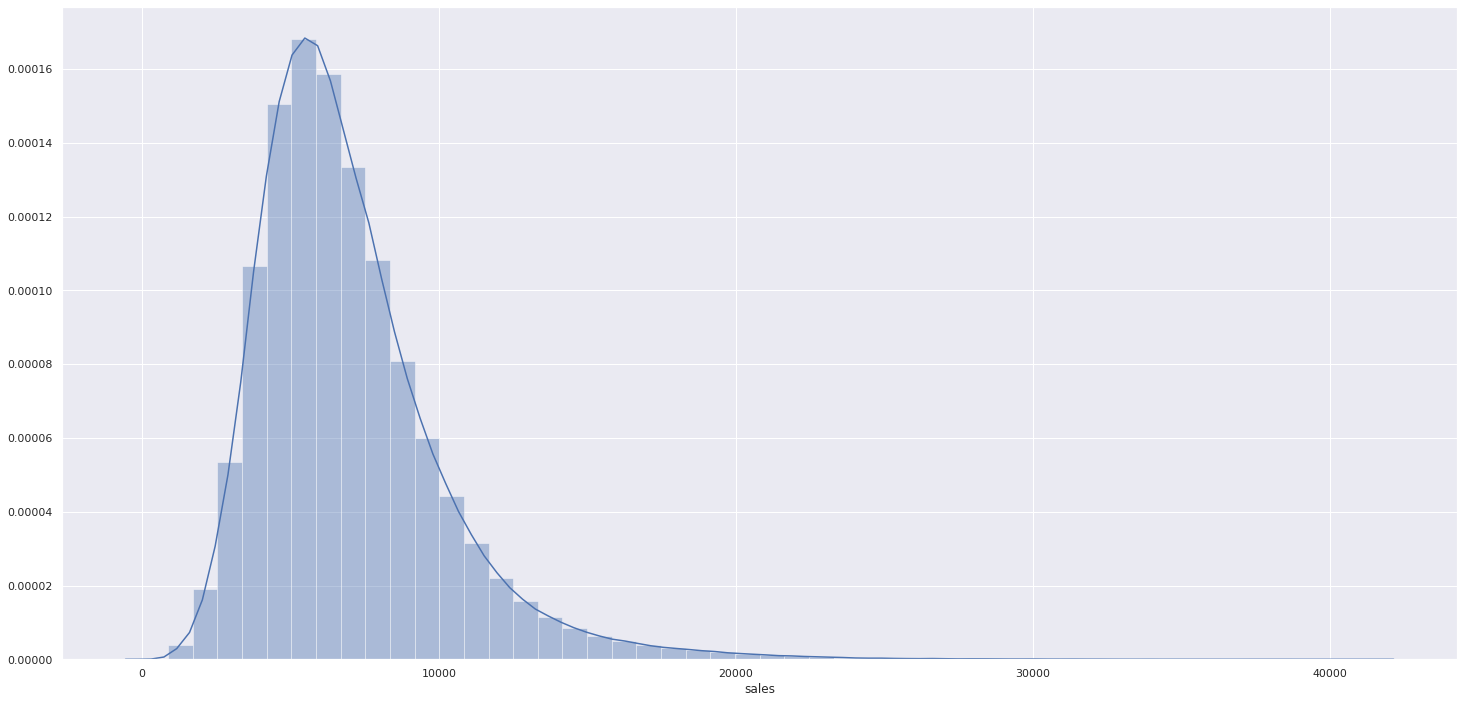

In [26]:
sns.distplot(df4['sales'])

### **4.1.2 Numerical Variable**

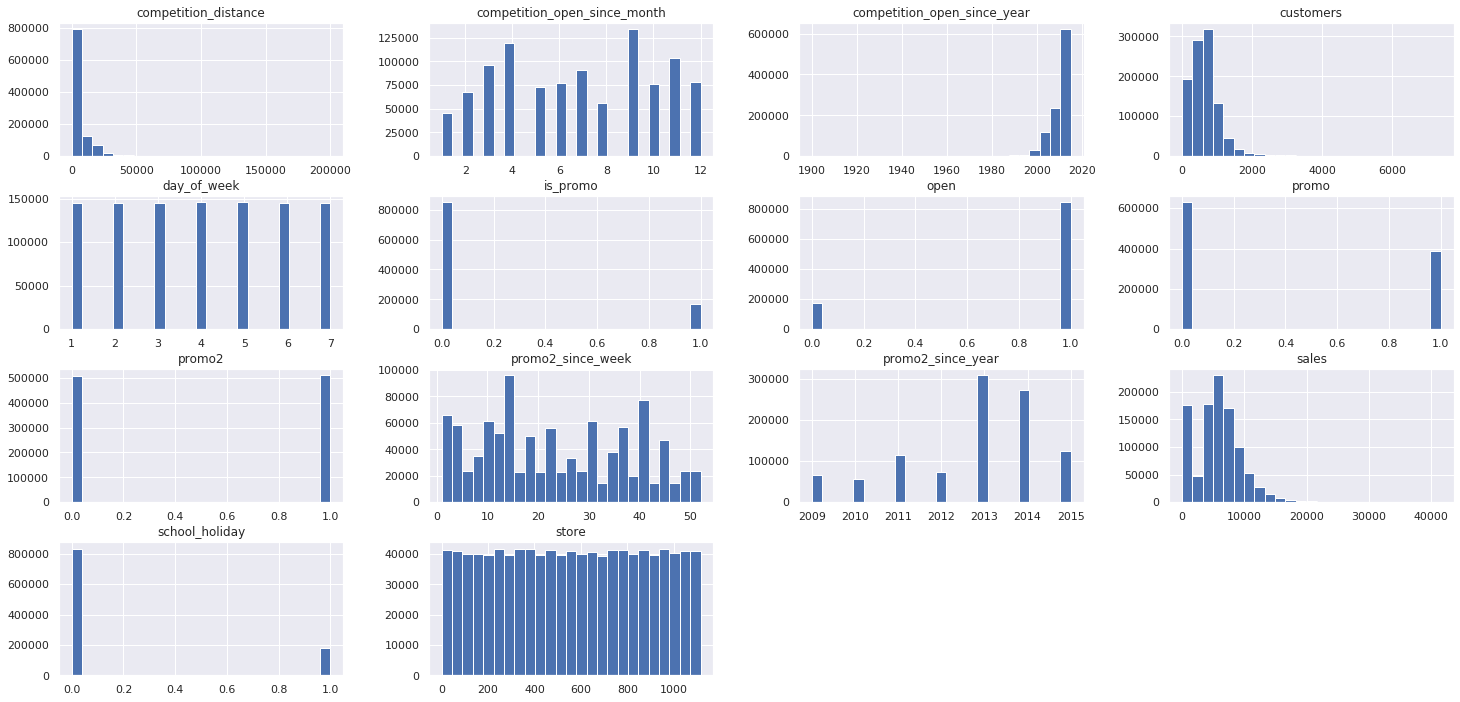

In [27]:
num_attributes.hist(bins = 25);

### **4.1.3 Categorical Variable**

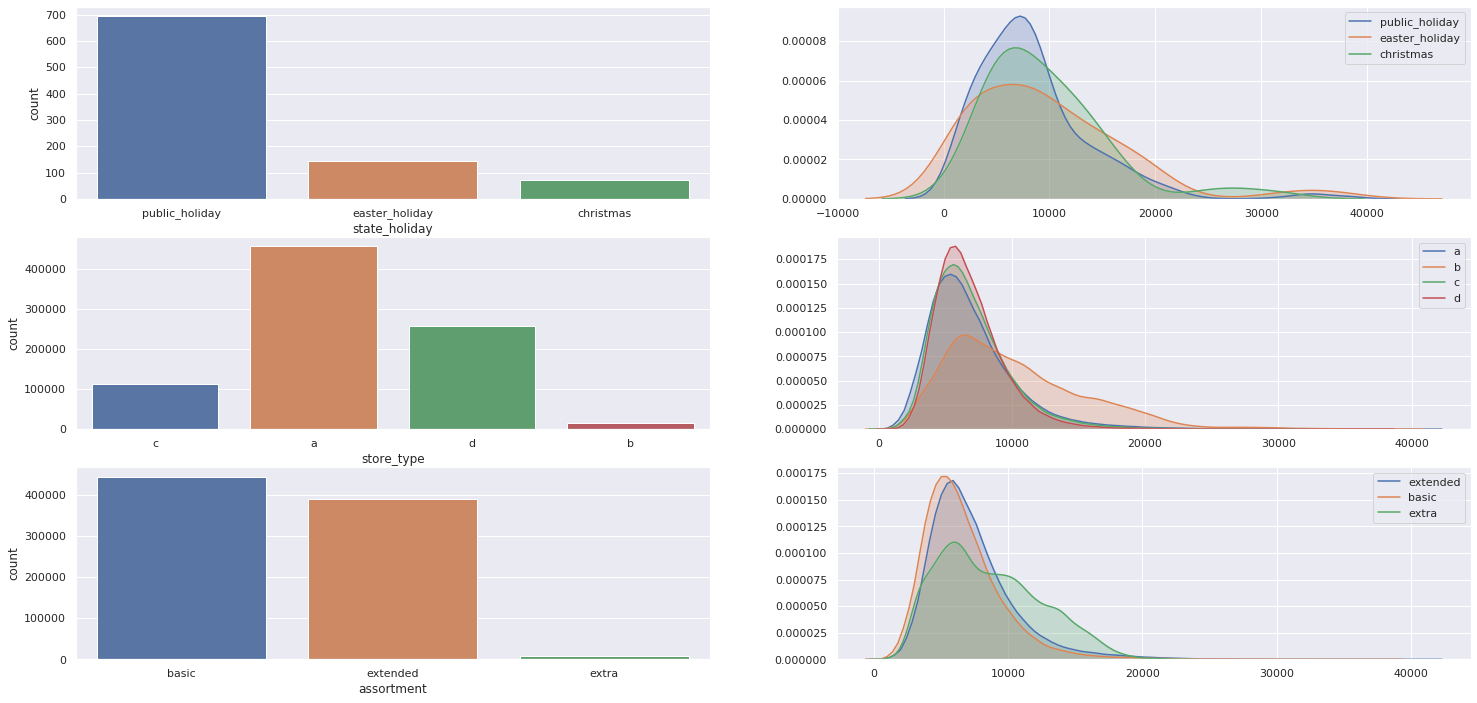

In [28]:
# state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])
plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade=True)

# store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade=True)

# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade=True)

## **4.2. Analise Bivariada**

### **4.2.0 Hipoteses**


#### **H1.** Lojas com maior sortimento deveriam vender mais.
**FALSA** Lojas com maior sortimento vendem MENOS.

In [29]:
df4.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                             int64
year_week                               object
competition_s

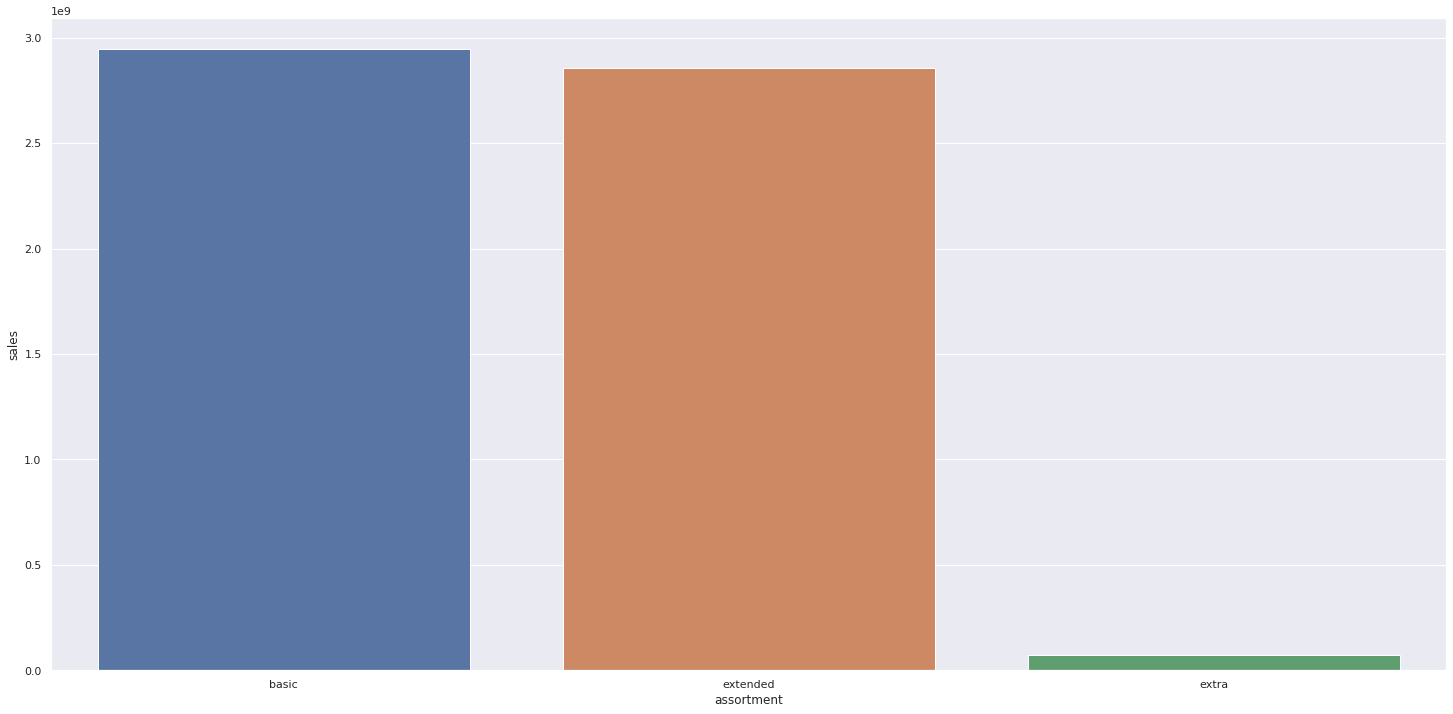

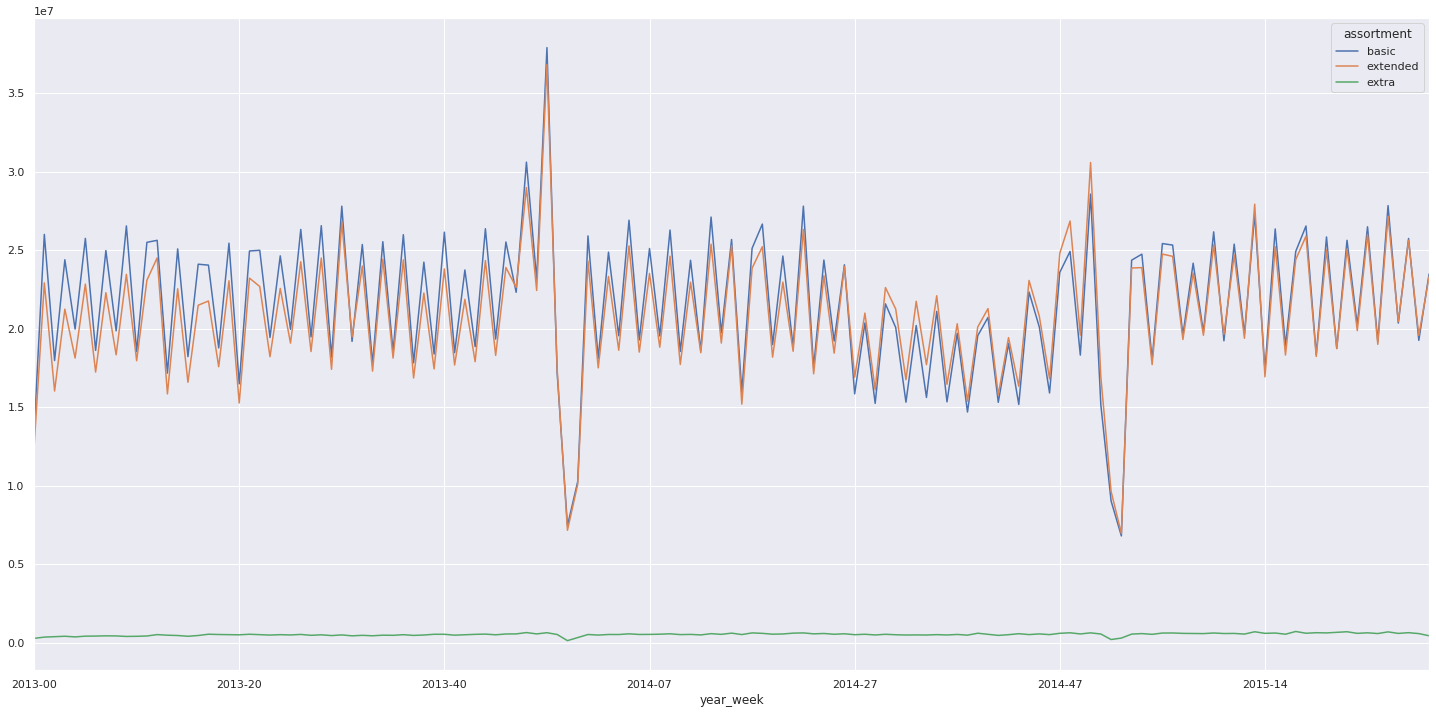

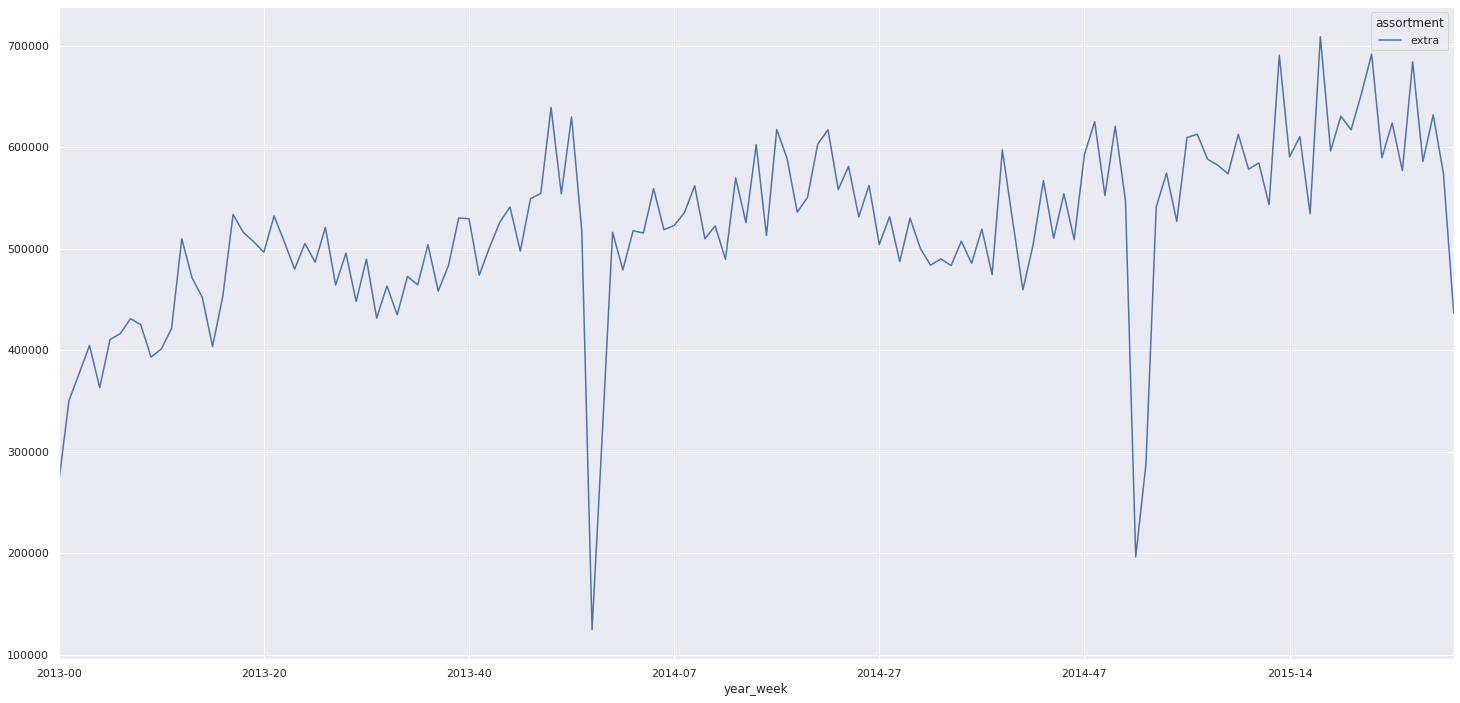

In [30]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

#### **H2.** Lojas com mais competidores proximos deveriam vender menos.
**FALSA** Lojas com competidores mais proximos vendem MAIS.

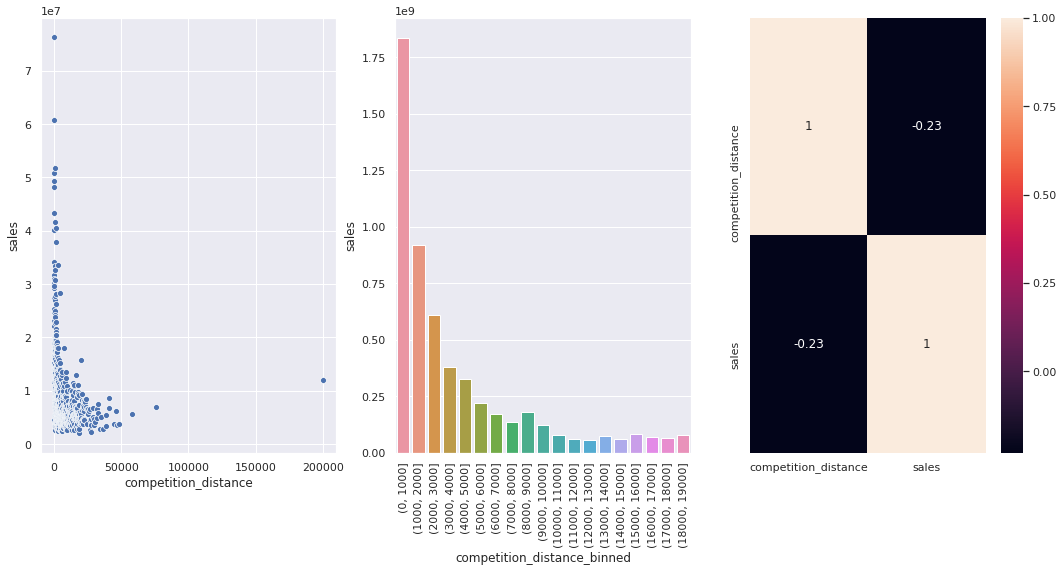

In [31]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize=(18,8))
plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1,3,2)
bins = list(np.arange(0,20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned',y='sales',data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### **H3.** Lojas com competidore a mais tempo deveriam vender mais.
**FALSA** Lojas com competidores mais proximos vendem MAIS.

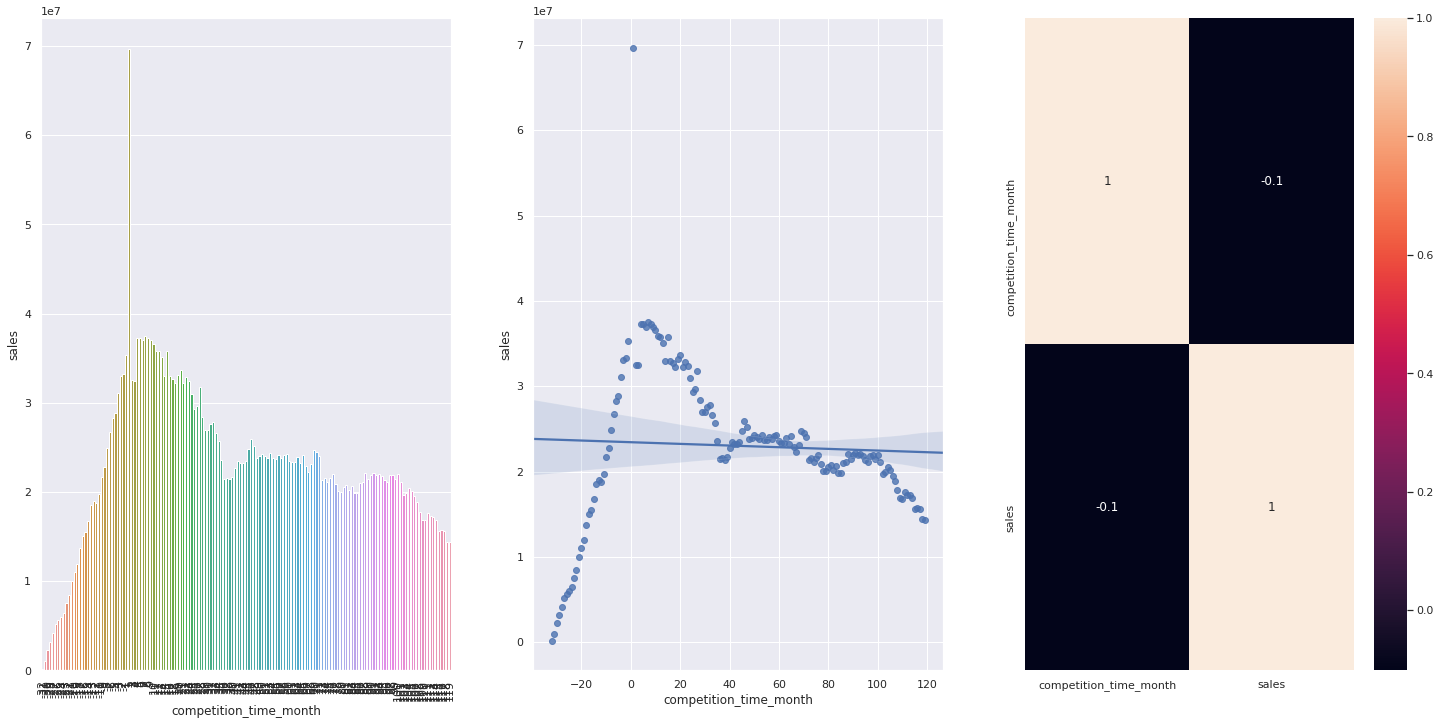

In [32]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

plt.subplot(1,3,1)
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


#### **H4.** Loja com promoçoes ativas a mais tempo deveriam vender mais.
**FALSA** Lojas com promocoes ativas por mais tempo vendem MENOS, depois de um certo periodo de promocao.

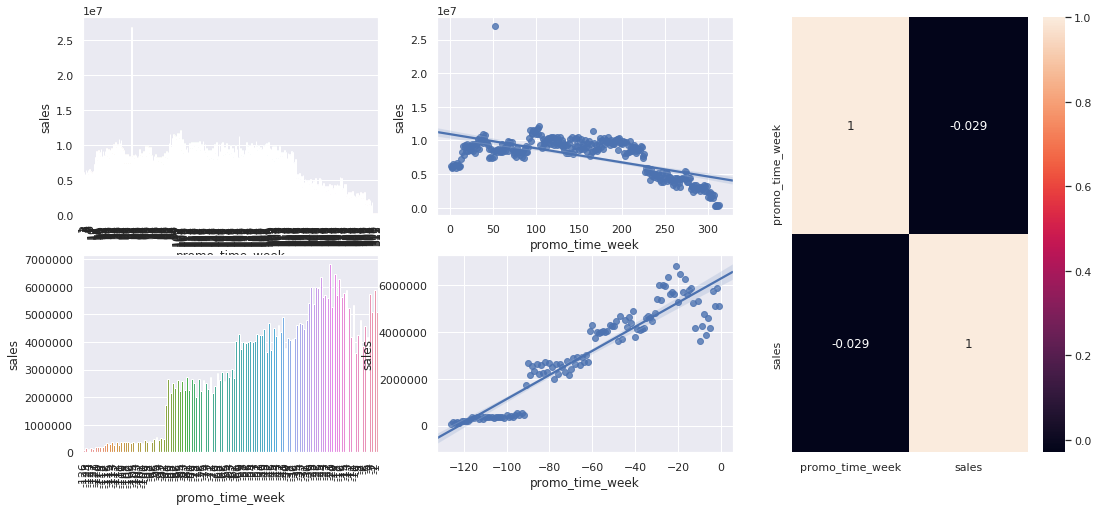

In [33]:
aux1=df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2,3)

plt.figure(figsize=(18,8))
plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #Promo extendida
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #Promo normal
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True)

#### <s>**H5.** Lojas com mais dias de promoçoes deveriam vender mais.</s>

#### **H6.** Loja com mais promoçoes consecutivas deveriam vender mais.
**FALSA** Lojas com promoções extendidas vendem MENOS.

<Figure size 1296x576 with 0 Axes>

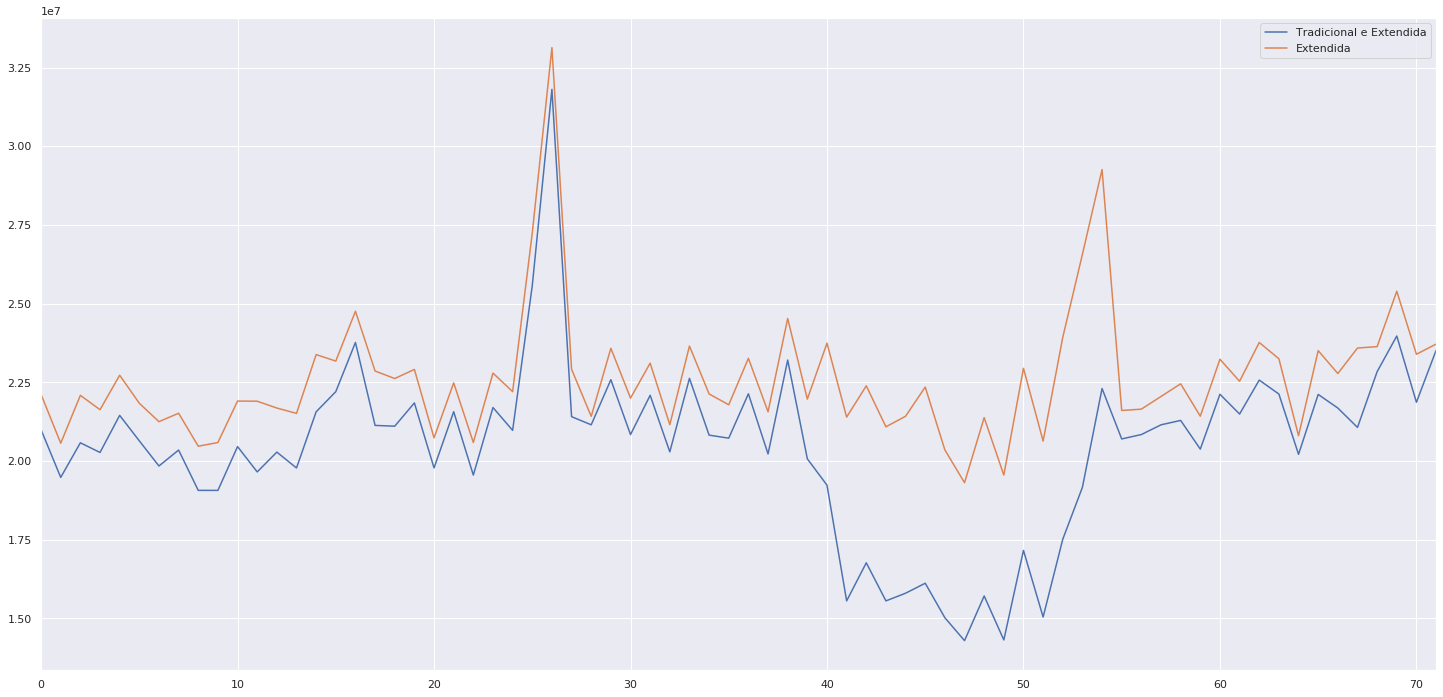

<Figure size 1296x576 with 0 Axes>

In [34]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
plt.figure(figsize=(18,8))
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
plt.figure(figsize=(18,8))
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional e Extendida', 'Extendida'])

#### **H7.**  Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas vendem MENOS no feriado de natal.

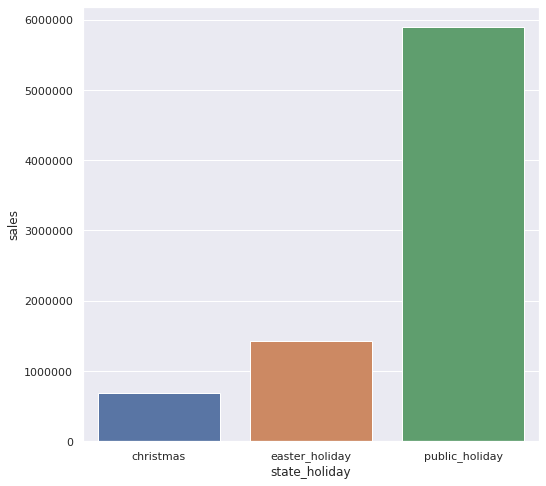

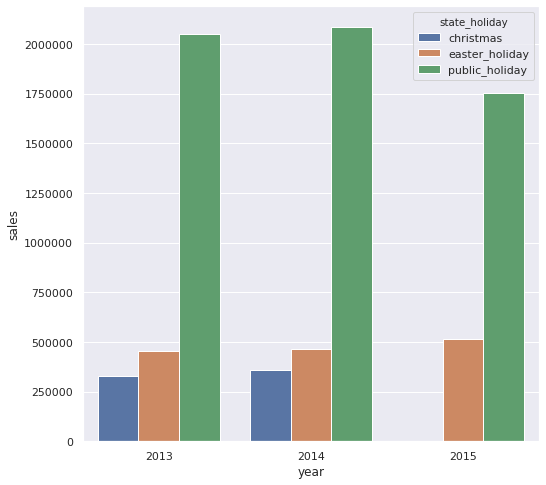

In [35]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.figure(figsize=(18,8))
plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales',hue='state_holiday', data=aux2)

#### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem MENOS ao longo do ano.

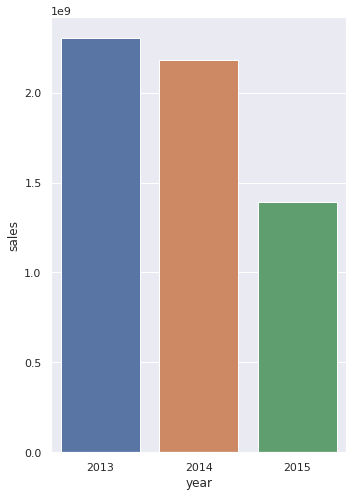

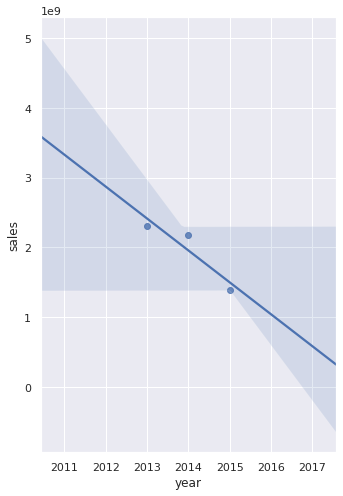

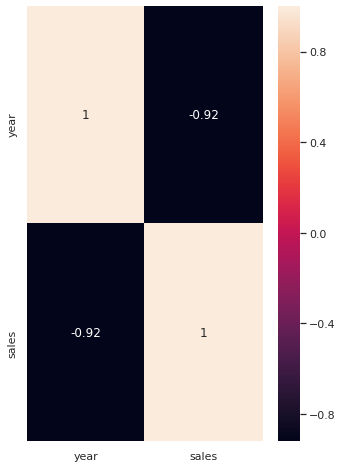

In [36]:
plt.figure(figsize=(18,8))
plt.subplot(1,3,1)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1)

plt.figure(figsize=(18,8))
plt.subplot(1,3,2
            )
sns.regplot(x='year', y='sales', data=aux1)

plt.figure(figsize=(18,8))
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas Vendem MENOS no segundo semestre do ano.

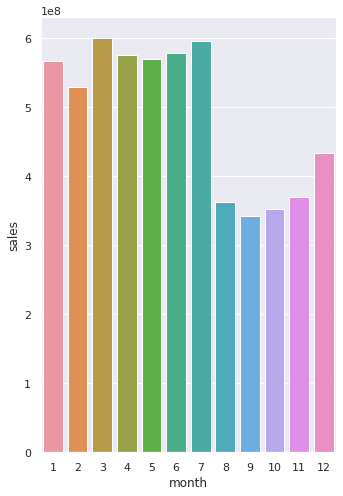

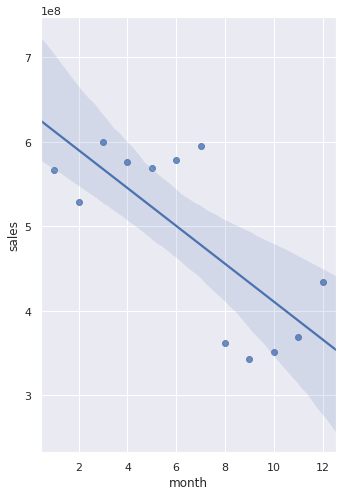

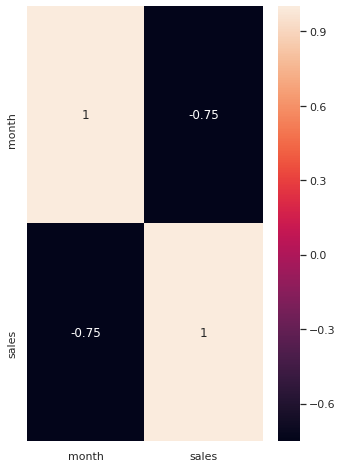

In [37]:
plt.figure(figsize=(18,8))
plt.subplot(1,3,1)
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=aux1)

plt.figure(figsize=(18,8))
plt.subplot(1,3,2
            )
sns.regplot(x='month', y='sales', data=aux1)

plt.figure(figsize=(18,8))
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### **H10.**  Lojas deveriam vender Mais depois do dia 10 de cada mes.
**VERDADEIRA** Lojas vendem  MAIS depois do dia 10.

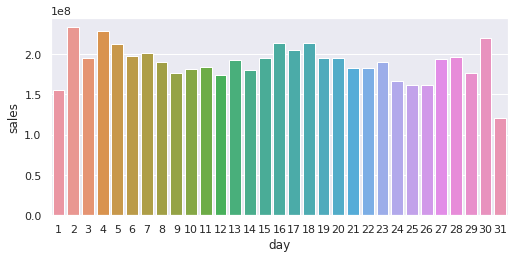

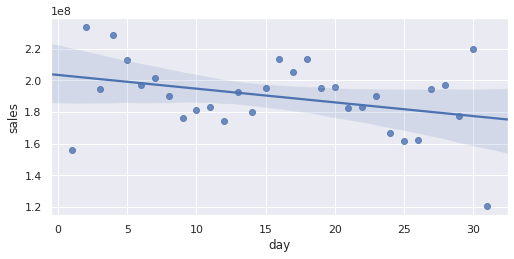

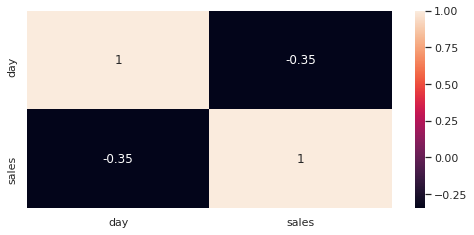

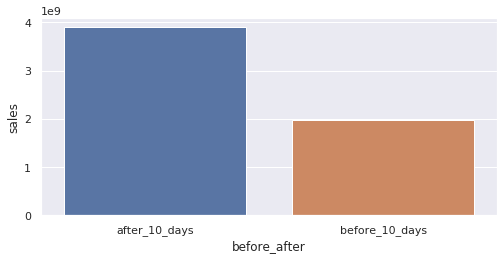

In [38]:
plt.figure(figsize=(18,8))
plt.subplot(2,2,1)
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data=aux1)

plt.figure(figsize=(18,8))
plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1)

plt.figure(figsize=(18,8))
plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.figure(figsize=(18,8))
plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2)

#### **H11.** Lojas deveriam vender menos nos finais de semana.
**VERDADEIRA** Lojas vendem  MENOS nos finais de semana.

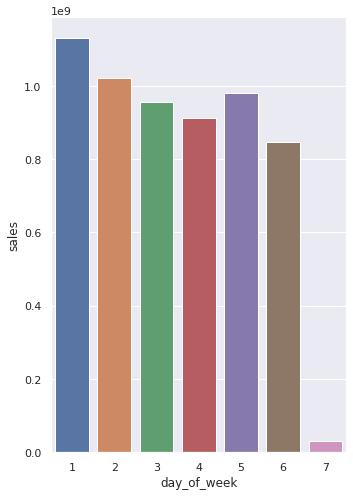

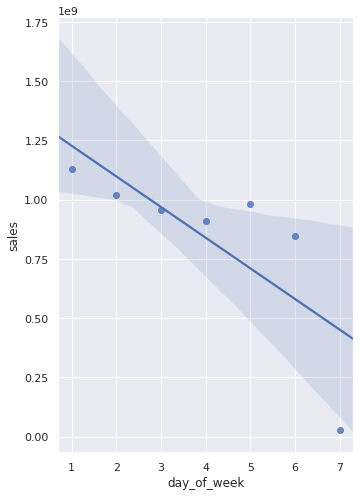

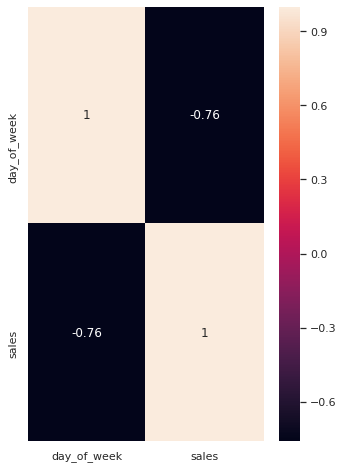

In [39]:
plt.figure(figsize=(18,8))
plt.subplot(1,3,1)
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.figure(figsize=(18,8))
plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.figure(figsize=(18,8))
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### **H12.**  Lojas deveriam vender menos durante  os feriados escolares.
**VERDADEIRA** Lojas vendem  MENOS nos feriados escolares.

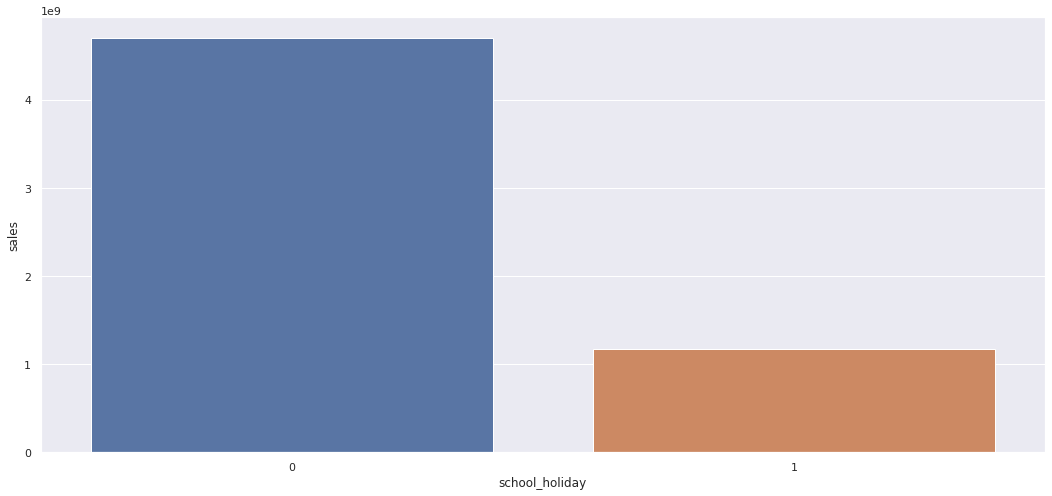

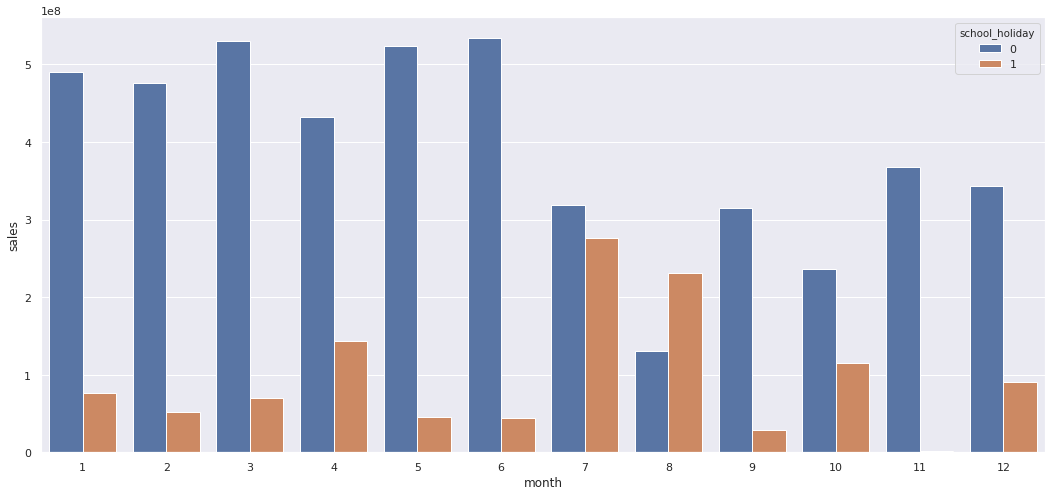

In [40]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.figure(figsize=(18,8))
sns.barplot(x='school_holiday', y='sales', data=aux1)

aux2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.figure(figsize=(18,8))
sns.barplot(x='month', y='sales',hue='school_holiday', data=aux2)

### **4.2.1 Resumo das hipoteses**

In [41]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa'],
      ]
print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## **4.3. Analise Multivariada**

### **4.3.1 Numerical Attributes**

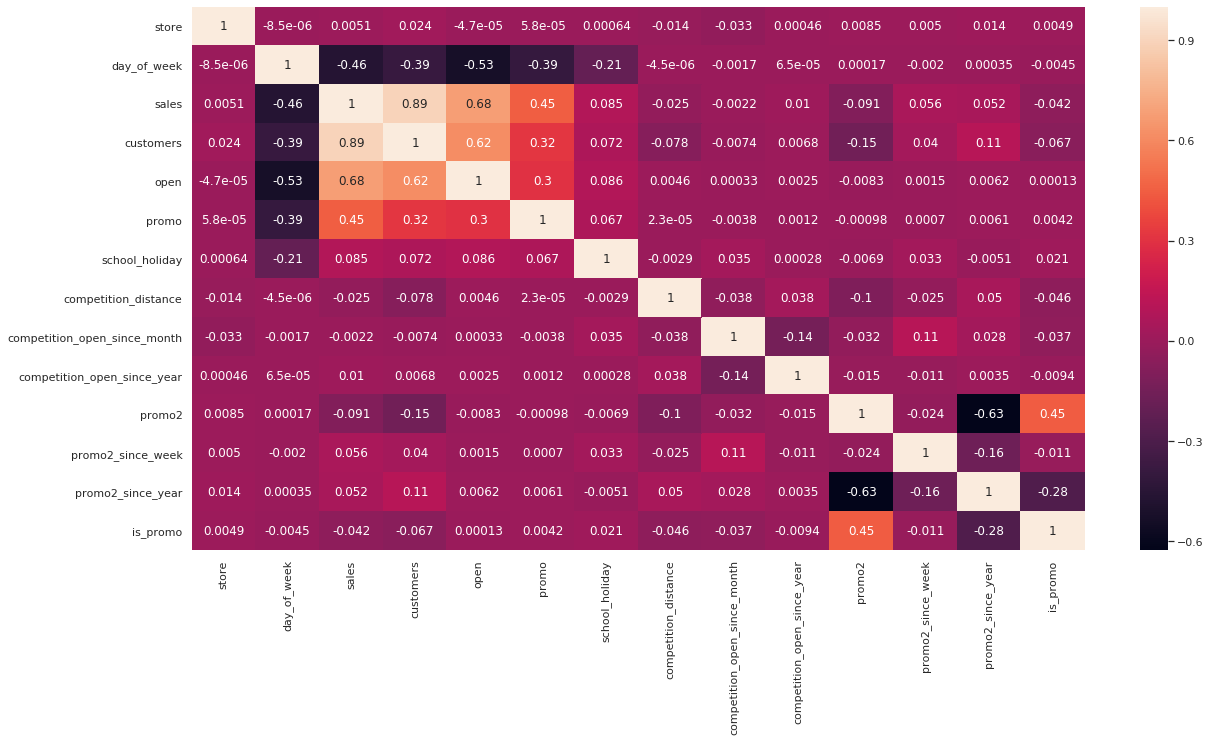

In [42]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(correlation, annot=True)

### **4.3.2 Categorical Attributes**

In [43]:
a = df4.select_dtypes(include='object')
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [44]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday': [a1,a2,a3],
              'store_type': [a4,a5,a6],
              'assortment': [a7,a8,a9]})

d = d.set_index(d.columns)

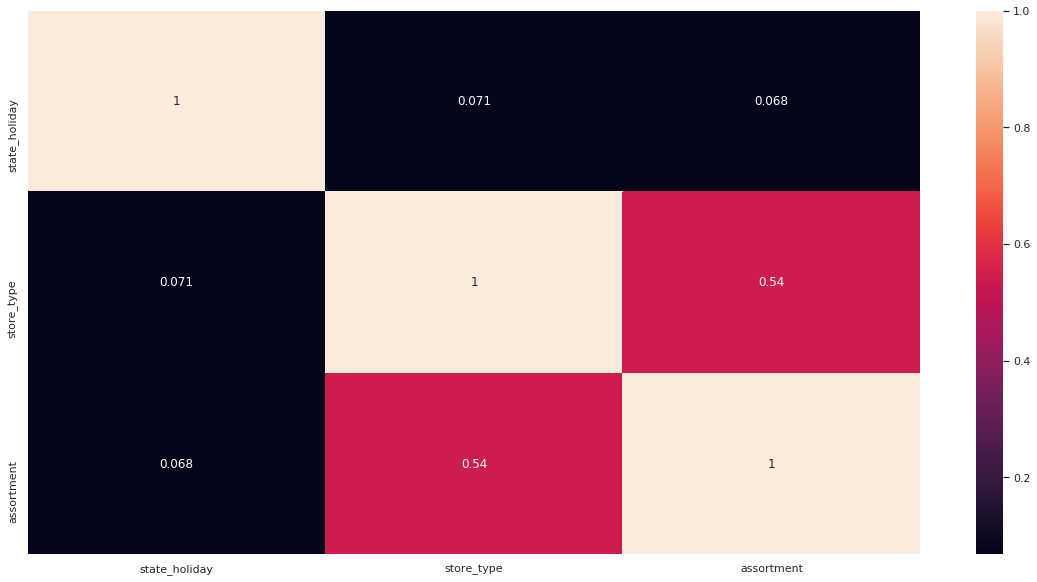

In [45]:
plt.figure(figsize=(20,10))
sns.heatmap(d, annot=True)

# **5.0. Passo 05 - Preparação dos Dados**

In [46]:
df5 = df4.copy()

## **5.1. Normalizacao**

## **5.2. Rescaling**

In [47]:
a = df5.select_dtypes(include=['int64', 'float64'])

In [48]:
rs = RobustScaler()
mms = MinMaxScaler()
#competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

#competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )

#promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb') )

#year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb') )

## **5.3. Tranformacao**

### **5.3.1 Encoding**

In [49]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### **5.3.2 Response Variable Transformation**

In [50]:
df5['sales'] = np.log1p(df5['sales'])

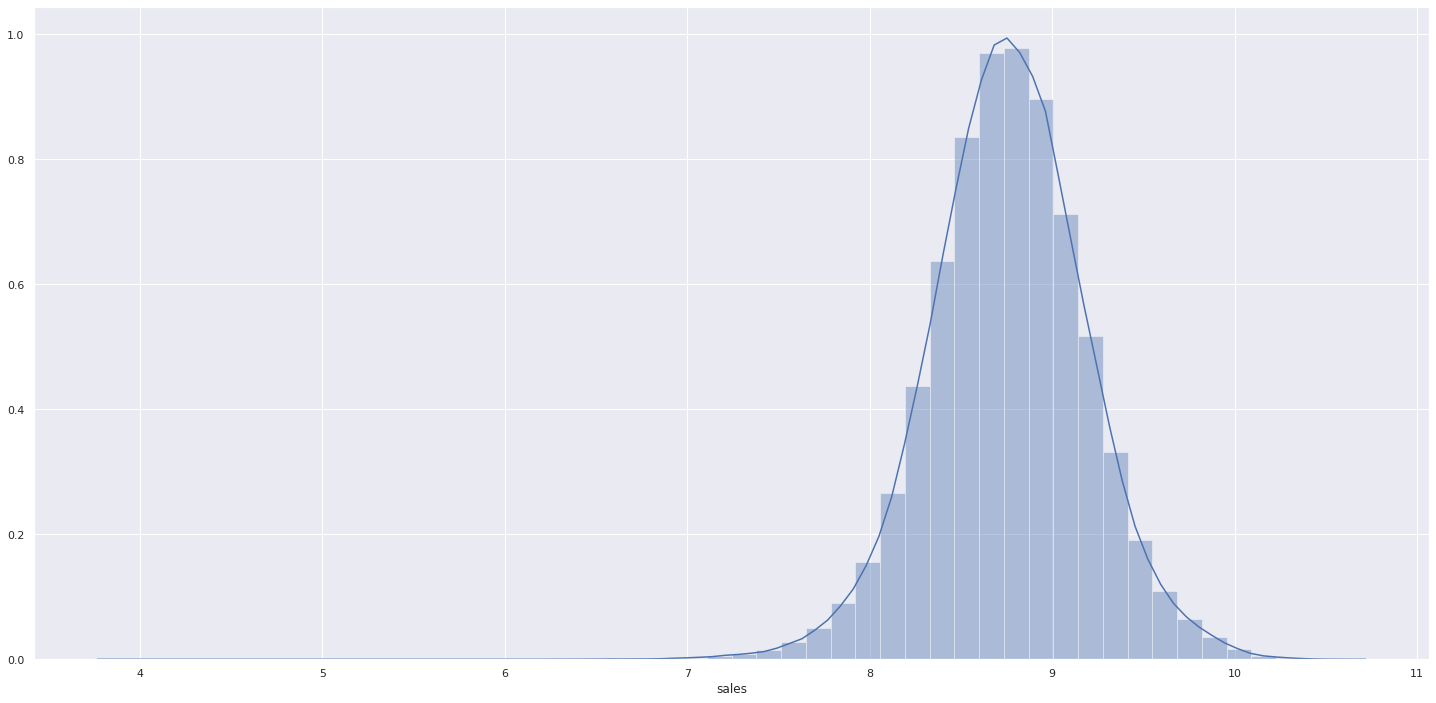

In [51]:
sns.distplot(df5['sales'])

### **5.3.2 Nature Transformation**

In [52]:
#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))
#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))
#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))
#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

In [53]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# **6.0. Passo 06 - Feature Selection**

In [54]:
df6 = df5.copy()

## **6.1. Split dataframe into training and test dataset**

In [55]:
cols_drop = ['week_of_year', 'day','month', 'day_of_week', 'promo_since', 'competition_since','year_week' ]
df6=df6.drop(cols_drop, axis=1)

In [56]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [57]:
#Training dateset
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

#Teste dateset
X_test = df6[df6['date'] > '2015-06-19']
Y_test = X_test['sales']

print('Training min date: {}'.format(X_train['date'].min()))
print('Training max date: {}'.format(X_train['date'].max()))

print('\nTest min date: {}'.format(X_test['date'].min()))
print('Test max date: {}'.format(X_test['date'].max()))

Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00

Test min date: 2015-06-20 00:00:00
Test max date: 2015-07-31 00:00:00


## **6.2. Boruta as Feature Selector**

In [58]:
# #training and test dateset for boruto
# X_train_n = X_train.drop(['date', 'sales'], axis=1).values
# Y_train_n = Y_train.values.ravel()

# #define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs = -1)

# #define boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n,Y_train_n)



### 6.2.1 Best Feature from Boruto

In [59]:
# cols_selected = boruta.support_.tolist()

# X_train_fs = X_train.drop(['date', 'sales'], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## **6.3 Manual Feature Selection**

In [60]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance', 
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',  
                        'month_cos',
                        'month_sin',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

cols_not_selected_boruta = ['is_promo',
                            'school_holiday',
                            'state_holiday_christmas',
                            'state_holiday_easter_holiday',
                            'state_holiday_public_holiday',
                            'state_holiday_regular_day',
                            'year']

#columns to add
feat_to_add = ['date', 'sales']

#Final Features
cols_selected_boruta_full = cols_selected_boruta.copy()

cols_selected_boruta_full.extend(feat_to_add)

In [61]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# **7.0. Passo 07 -  Modelos de Machine Learning**

In [62]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#Times Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## **7.1. Average Model**

In [63]:
# aux1 = x_test.copy()
# aux1['sales'] = Y_test.copy()

# #Prediction
# aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
# aux1 = pd.merge(aux1, aux2, how='left', on='store')
# yhat_baseline = aux1['predictions']

# #Perfomace
# baseline_result = ml_error('Average Model', np.expm1(Y_test), np.expm1(yhat_baseline))
# baseline_result

## **7.2. Linear Regression Model**

In [64]:
# #Model
# lr = LinearRegression().fit(x_train, Y_train)

# #Prediction
# yhat_lr = lr.predict(x_test)

# #Perfomance
# lr_result = ml_error('Linear Regressor', np.expm1(Y_test), np.expm1(yhat_lr))
# lr_result

### **7.2.1 Linear Regression Model - Cross Validation**

In [65]:
# lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
# lr_result_cv

## **7.3. Linear Regression Regularized Model**

In [66]:
# #Model
# lrr = Lasso(alpha=0.01).fit(x_train, Y_train)

# #Prediction
# yhat_lrr = lrr.predict(x_test)

# #Perfomance
# lrr_result = ml_error('Linear Regressor Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
# lrr_result

### **7.3. Linear Regression Regularized Model - Cross Validation**

In [67]:
# lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
# lrr_result_cv

## **7.4. Random Forest Regressor**

In [68]:
# #Model
# rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, Y_train)

# #Prediction
# yhat_rf = rf.predict(x_test)

# #Perfomance
# rf_result = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
# rf_result

### **7.4.1 Random Forest Regressor - Cross Validation**

In [69]:
# rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
# rf_result_cv

## **7.5. XGBoost Regressor**

In [70]:
# #Model
# model_xgb = xgb.XGBRegressor(objetive='reg:squarederror', n_estimators=100, eta=0.01,
#                              max_depth=10, subsample=0.7, colsample_bytree=0.9).fit(x_train, Y_train)

# #Prediction
# yhat_xgb = model_xgb.predict(x_test)

# #Pexgbomance
# xgb_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
# xgb_result

### **7.5.1 XGBoost Regressor - Cross Validation**

In [71]:
# xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor ', model_xgb, verbose=True)
# xgb_result_cv

## **7.6. Compare Models Performace**

### **7.6.1 Single Performace**

In [72]:
#modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])

modelling_result = pd.DataFrame([['Random Forest Regressor', 680.0870972462793,
        0.10021478919593955, 1013.3784533932647],
       ['XGBoost Regressor', 866.810588673218, 0.1253757460824176,1282.1788488514915],
       ['Average Model', 1366.1283512796585, 0.4520870609728856,1854.2633162967793],
       ['Linear Regressor', 1868.7395196248553, 0.2937451328722636,2675.947846351803],
       ['Linear Regressor Lasso', 1894.132074829927, 0.29016820268161864,2750.81867176932]])

modelling_result.columns = ['Model Name','MAE','MAPE','RMSE']
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.087097,0.100215,1013.378453
1,XGBoost Regressor,866.810589,0.125376,1282.178849
2,Average Model,1366.128351,0.452087,1854.263316
3,Linear Regressor,1868.739520,0.293745,2675.947846
4,Linear Regressor Lasso,1894.132075,0.290168,2750.818672


### **7.6.2 Real Performace - Cross Validation**

In [73]:
#modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])

modelling_result_cv = pd.DataFrame([['Linear Regression', '2081.73 +/- 295.63', '0.3 +/- 0.02','2952.52 +/- 468.37'],
                                    ['Lasso', '2116.38 +/- 341.5', '0.29 +/- 0.01','3057.75 +/- 504.26'],
                                    ['Random Forest Regressor', '837.15 +/- 217.7', '0.12 +/- 0.02','1256.14 +/- 318.1'],
                                    ['XGBoost Regressor ', '1029.33 +/- 149.52', '0.14 +/- 0.01','1480.28 +/- 203.06']])
modelling_result_cv.columns = ['Model Name','MAE','MAPE','RMSE']
modelling_result_cv

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
1,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
2,Random Forest Regressor,837.15 +/- 217.7,0.12 +/- 0.02,1256.14 +/- 318.1
3,XGBoost Regressor,1029.33 +/- 149.52,0.14 +/- 0.01,1480.28 +/- 203.06


# **8.0. Passo 08 -  Hyper Parameter Fine Tune**

## **8.1. Random Search**

In [74]:
# param = {'n_estimators':[15,17,25,35],
#          'eta':[0.01,0.03],
#          'max_depth':[3,5,9],
#          'subsample':[0.1,0.5,0.7],
#          'colsample_bytree':[0.3,0.7,0.9],
#          'min_child_weight':[3,8,15]}

# MAX_EVAL = 10

In [75]:
# final_result=pd.DataFrame()
# for i in range(MAX_EVAL):
#   #values for param random
#   hp = {k: random.sample(v,1)[0] for k,v in param.items()}
#   print(hp)
#   #Model
#   model_xgb = xgb.XGBRegressor(objetive = 'reg:squarederror', 
#                               n_estimators = hp['n_estimators'], 
#                               eta = hp['eta'],
#                               max_depth = hp['max_depth'],
#                               subsample = hp['subsample'],
#                               colsample_bytree = hp['colsample_bytree'],
#                               min_child_weight = hp['min_child_weight'])

#   #Pexgbomance
#   result = cross_validation( x_training, 2,'XGBoost Regressor', model_xgb)
#   final_result = pd.concat([final_result, result])

# final_result  

## **8.2. Final Model**

In [76]:
param_tuned = {'n_estimators': 3000,
         'eta': 0.03,
         'max_depth': 5,
         'subsample': 0.7,
         'colsample_bytree': 0.7,
         'min_child_weight': 3}

In [77]:
#Model
model_xgb_tuned = xgb.XGBRegressor(objetive = 'reg:squarederror', 
                            n_estimators = param_tuned['n_estimators'], 
                            eta = param_tuned['eta'],
                            max_depth = param_tuned['max_depth'],
                            subsample = param_tuned['subsample'],
                            colsample_bytree = param_tuned['colsample_bytree'],
                            min_child_weight = param_tuned['min_child_weight']).fit(x_train, Y_train)

#Prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

#Performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned 

[09:24:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,672.225575,0.098445,973.119071


# **9.0. Passo 09 -  Tradução e Interpretação de ERRO**

In [78]:
df9 = X_test[cols_selected_boruta_full]

#Rescale
df9['sales'] = np.expm1(df9['sales'])
df9['prediction'] = np.expm1(yhat_xgb_tuned)

## **9.1. Business Perfomance**

In [79]:
#sum of prediction
df91 = df9[['store', 'prediction']].groupby('store').sum().reset_index()

#MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'prediction']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],x['prediction'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'prediction']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'],x['prediction'])).reset_index().rename(columns={0:'MAPE'})

#merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91,df9_aux3, how='inner', on='store')

#scenarios
df92['worst_scenario'] = df92['prediction'] - df92['MAE']
df92['best_scenario'] = df92['prediction'] + df92['MAE']

#order columns
df92 = df92[['store','prediction','worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [80]:
df92.sample(5)

,store,prediction,worst_scenario,best_scenario,MAE,MAPE
972,973,249747.15625,249009.275092,250485.037408,737.881158,0.104938
200,201,192081.09375,191631.577155,192530.610345,449.516595,0.081424
91,92,222742.00000,222197.502808,223286.497192,544.497192,0.089205
822,823,210040.28125,209635.910746,210444.651754,404.370504,0.070968
1087,1088,192730.03125,192051.485060,193408.577440,678.546190,0.143642


In [81]:
df92.sort_values('MAPE',ascending=False).head()

,store,prediction,worst_scenario,best_scenario,MAE,MAPE
291,292,96610.859375,93132.812283,100088.906467,3478.047092,0.579136
908,909,226426.734375,218467.679865,234385.788885,7959.054510,0.542402
875,876,188227.812500,184194.915272,192260.709728,4032.897228,0.298480
594,595,372029.187500,368098.692912,375959.682088,3930.494588,0.274863
1013,1014,423424.718750,421465.675062,425383.762438,1959.043688,0.248055


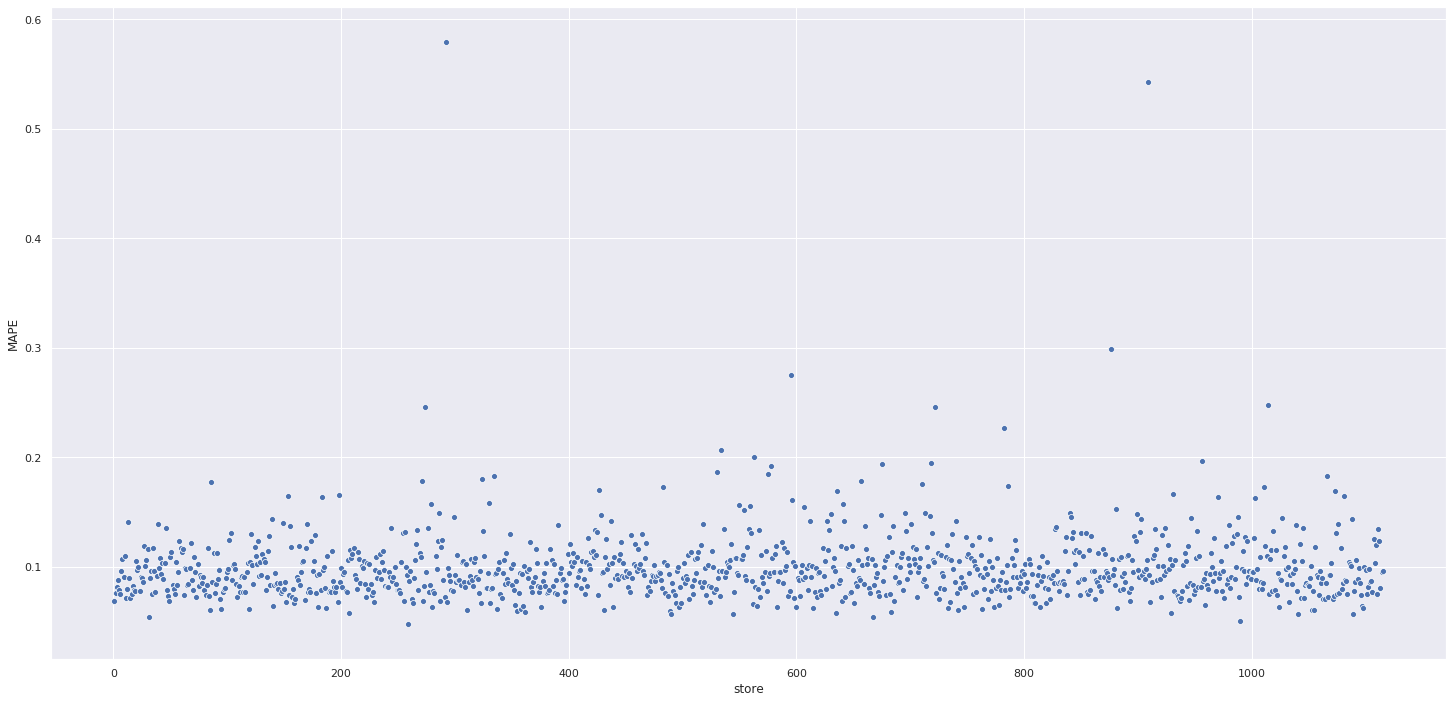

In [82]:
sns.scatterplot(x='store', y='MAPE', data=df92)

## **9.2. Total Perfomance**



In [83]:
df93 = df92[['prediction','worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenario', 0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)

## **9.3. Machine Learning Perfomance**

In [84]:
df9['error'] = df9['sales'] - df9['prediction']
df9['error_rate'] = df9['prediction'] / df9['sales']

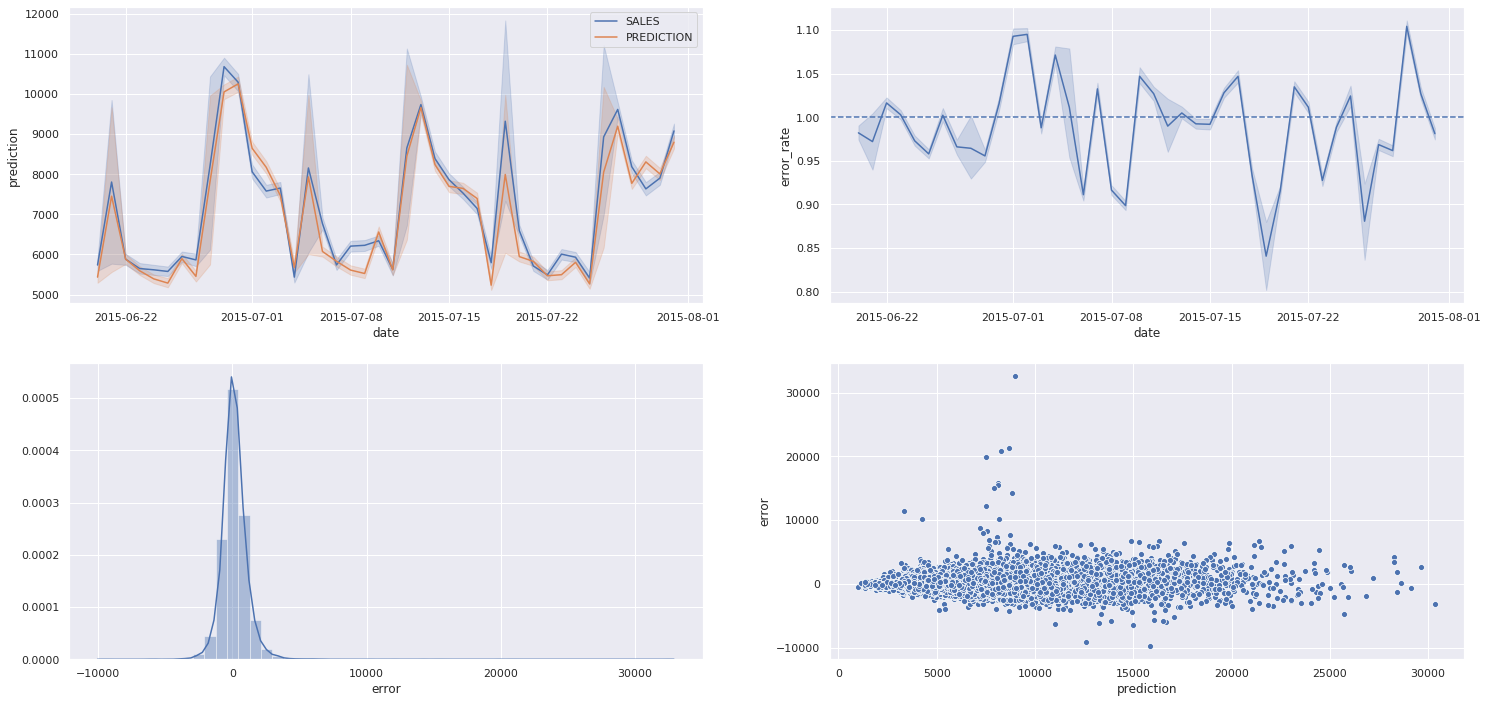

In [85]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='prediction', data=df9, label='PREDICTION')

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1,linestyle='--')

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(df9['prediction'],df9['error'])

# **10.0. Passo 10 -  Deploy Model To Production**

In [52]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open( 'model/model_rossmann.pkl', 'wb' ) )

NameError: name 'model_xgb_tuned' is not defined

## **10.1. RossMann Class**

In [16]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='/home/iago/repos/DataScience_Em_Producao/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## **10.2. API Handler**

In [17]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( '/home/iago/repos/DataScience_Em_Producao/model/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## **10.3. API Tester**

In [23]:
import requests

In [24]:
# loading test dataset
df10 = pd.read_csv( '/home/iago/repos/DataScience_Em_Producao/data/test.csv' )

In [25]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [26]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [27]:
# API Call
url = 'http://0.0.0.0:5000/rossmann/predict'
#url = 'https://rossmann-model-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 500


In [28]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [11]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )


NameError: name 'd1' is not defined